## Collect

Na EximiaCo, acreditamos que o "código" é a principal fonte da verdade. Por isso, valorizamos dados extraídos do código fonte.

Nesse exercício, coletamos informações com relação ao volume de modificações (changes) dos arquivos de um repositório GIT na máquina local. 

Consideramos os últimos três meses de modificações porque entendemos que essa é uma janela relevante para mostrar o "momento do time"

In [1]:
import os.path
! pip install GitPython --quiet

In [2]:
def safe_get(tree, path, default=None):
    try:
        return tree[path]
    except KeyError:
        return default

In [3]:
import git
from datetime import datetime, timedelta

def get_commits_last_three_months(repo_path, branch_name):
    repo = git.Repo(repo_path)
    three_months_ago = datetime.now() - timedelta(days=90)
    
    commits = []

    # Iterar sobre os commits na branch especificada
    for commit in repo.iter_commits(branch_name, since=three_months_ago.isoformat()):
        for file_stat in commit.stats.files.items():
            file_name, stats = file_stat
            entry = safe_get(commit.tree, file_name)
            lines = entry.data_stream.read().count(b'\n') + 1 if entry else 0
            commit_info = {
                'sha': commit.hexsha,
                'author': commit.author.name,
                'file': file_name,
                'changes': stats['lines'],
                'insertions' : stats['insertions'],
                'deletions': stats['deletions'],
                'bytes': entry.size if entry else 0,
                'lines': lines
            }
            commits.append(commit_info)
            
    return commits

In [4]:
commits = get_commits_last_three_months("~/Documents/GitHub/ravendb", "v6.0")

In [5]:
len(commits)

6956

In [6]:
! pip install pandas --quiet

In [7]:
import pandas as pd

In [8]:
commits_df = pd.DataFrame(commits)
commits_df.head()

,sha,author,file,changes,insertions,deletions,bytes,lines
0,99fe8133164d9d09f0f7f66891d890ab3c0d5b9e,Arkadiusz Palinski,test/SlowTests/Sharding/Backup/ShardedBackupTe...,9,6,3,38460,859
1,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Raven.Server/Documents/Indexes/MapReduce/M...,7,5,2,15707,364
2,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.MultiTree.cs,7,5,2,16090,393
3,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.Stream.cs,7,5,2,19466,595
4,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.cs,2,1,1,61978,1710


In [9]:
commits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sha         6956 non-null   object
 1   author      6956 non-null   object
 2   file        6956 non-null   object
 3   changes     6956 non-null   int64 
 4   insertions  6956 non-null   int64 
 5   deletions   6956 non-null   int64 
 6   bytes       6956 non-null   int64 
 7   lines       6956 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 434.9+ KB


## Organize

Vale a pena adicionarmos algumas colunas ao nosso dataset, como, por exemplo, a pasta raiz

In [10]:
import os 

def get_root(path):
    parts = path.split(os.sep)
    return parts[0] if len(parts) > 1 else None

def get_code_project(path):
    parts = path.split(os.sep)
    return parts[1] if len(parts) > 2 else None

commits_df['root'] = commits_df['file'].apply(get_root)
commits_df['code_project'] = commits_df['file'].apply(get_code_project)
commits_df

,sha,author,file,changes,insertions,deletions,bytes,lines,root,code_project
0,99fe8133164d9d09f0f7f66891d890ab3c0d5b9e,Arkadiusz Palinski,test/SlowTests/Sharding/Backup/ShardedBackupTe...,9,6,3,38460,859,test,SlowTests
1,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Raven.Server/Documents/Indexes/MapReduce/M...,7,5,2,15707,364,src,Raven.Server
2,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.MultiTree.cs,7,5,2,16090,393,src,Voron
3,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.Stream.cs,7,5,2,19466,595,src,Voron
4,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.cs,2,1,1,61978,1710,src,Voron
...,...,...,...,...,...,...,...,...,...,...
6951,27496e203c2e3bf4fffec62f2f250f6cbdbab602,Grisha Kotler,src/Raven.Server/Documents/PeriodicBackup/Peri...,10,5,5,48218,1091,src,Raven.Server
6952,27496e203c2e3bf4fffec62f2f250f6cbdbab602,Grisha Kotler,src/Raven.Server/Documents/Subscriptions/Subsc...,6,3,3,37993,805,src,Raven.Server
6953,27496e203c2e3bf4fffec62f2f250f6cbdbab602,Grisha Kotler,test/SlowTests/Server/Documents/PeriodicBackup...,8,4,4,205425,4074,test,SlowTests
6954,27496e203c2e3bf4fffec62f2f250f6cbdbab602,Grisha Kotler,test/StressTests/Server/Documents/PeriodicBack...,2,1,1,8851,169,test,StressTests


O próximo passo é agrupar as informações de forma a gerar insights relevantes.

Quando analisamos o volume de alterações em um repositório, é importante analisar tanto a quantidade de changes por arquivo, para identificar quais são os arquivo mais modificados, como também o volume de changes por autor. Dessa forma, entendemos quem são os desenvolvedores com maior relevância no time, pelo menos na história recente.

In [11]:
summary_per_file = commits_df.groupby('file')['changes'].sum().reset_index()

# Ordenar o resultado para ver os arquivos com mais mudanças primeiro
summary_per_file_sorted = summary_per_file.sort_values(by='changes', ascending=False)

# Exibir os resultados
summary_per_file_sorted.head(10)

,file,changes
564,src/Raven.Studio/package-lock.json,311855
1700,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1055,src/Raven.Studio/typescript/components/pages/r...,2718
1037,src/Raven.Studio/typescript/components/pages/r...,2619
1315,src/Sparrow/Memory.cs,1816
1154,src/Raven.Studio/typescript/viewmodels/databas...,1810
1535,test/SlowTests/Issues/RavenDB-19922.cs,1766
1454,test/SlowTests/Client/Subscriptions/Concurrent...,1695
796,src/Raven.Studio/typescript/components/common/...,1605
1733,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508


Eventualmente, já na primeira análise, identifica-se algum desvio. Por exemplo, coleta de arquivos que não são relevantes para a análise. 

O ideal, durante a organização, é promover a limpeza dos dados.

In [12]:
filtered_commits_df = commits_df[commits_df['file'] != 'src/Raven.Studio/package-lock.json'].copy()
summary_per_file = filtered_commits_df.groupby('file')['changes'].sum().reset_index()
summary_per_file_sorted = summary_per_file.sort_values(by='changes', ascending=False)
summary_per_file_sorted.head(10)

,file,changes
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1054,src/Raven.Studio/typescript/components/pages/r...,2718
1036,src/Raven.Studio/typescript/components/pages/r...,2619
1314,src/Sparrow/Memory.cs,1816
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695
795,src/Raven.Studio/typescript/components/common/...,1605
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508
1040,src/Raven.Studio/typescript/components/pages/r...,1432


In [13]:
summary_per_author = filtered_commits_df.groupby('author')['changes'].sum().reset_index()
summary_per_author_sorted = summary_per_author.sort_values(by='changes', ascending=False)
summary_per_author_sorted

,author,changes
3,Damian Olszewski,48448
1,Arkadiusz Paliński,31428
0,Arkadiusz Palinski,28402
17,Paweł Pekról,24876
4,Federico Lois,7070
11,Maciej Aszyk,6193
26,shaharhikri,4912
14,Mateusz,4012
15,Michał Leśniak,3018
16,Pawel Pekrol,2772


Outras vezes, também, é possível identificar nos dados algumas inconsistências, como, por exemplo, aqui, autores que aparecem na lista como diferentes, mas são a mesma pessoa.

O ideal, também, é consolidar a lista.

In [14]:
sorted(commits_df['author'].unique())

['Arkadiusz Palinski',
 'Arkadiusz Paliński',
 'Bartosz Piekarski',
 'Damian Olszewski',
 'Federico Lois',
 'Gracjan Sadowicz',
 'Grisha Kotler',
 'Igal Merhavia',
 'James Thompson',
 'Karmel Indych',
 'Lev Skuditsky',
 'Maciej Aszyk',
 'Marcin Lewandowski',
 'Marko Lahma',
 'Mateusz',
 'Michał Leśniak',
 'Pawel Pekrol',
 'Paweł Pekról',
 'Rafal Kwiatkowski',
 'Stav Lagziel',
 'aviv',
 'danielle9897',
 'dependabot[bot]',
 'efrat@ravendb.net',
 'egor',
 'mateuszbartosik',
 'ravendb-bot',
 'shaharhikri',
 'shiranshalom',
 'unknown']

In [15]:
filtered_commits_df['author'] = filtered_commits_df['author'].replace('Arkadiusz Palinski', 'Arkadiusz Paliński')
filtered_commits_df['author'] = filtered_commits_df['author'].replace('Pawel Pekrol', 'Paweł Pekról')
filtered_commits_df['author'] = filtered_commits_df['author'].replace('Mateusz', 'Mateusz Bartosik')
filtered_commits_df['author'] = filtered_commits_df['author'].replace('mateuszbartosik', 'Mateusz Bartosik')
sorted(filtered_commits_df['author'].unique())

['Arkadiusz Paliński',
 'Bartosz Piekarski',
 'Damian Olszewski',
 'Federico Lois',
 'Gracjan Sadowicz',
 'Grisha Kotler',
 'Igal Merhavia',
 'James Thompson',
 'Karmel Indych',
 'Lev Skuditsky',
 'Maciej Aszyk',
 'Marcin Lewandowski',
 'Marko Lahma',
 'Mateusz Bartosik',
 'Michał Leśniak',
 'Paweł Pekról',
 'Rafal Kwiatkowski',
 'Stav Lagziel',
 'aviv',
 'danielle9897',
 'efrat@ravendb.net',
 'egor',
 'ravendb-bot',
 'shaharhikri',
 'shiranshalom',
 'unknown']

In [16]:
total_changes = summary_per_file_sorted['changes'].sum()
summary_per_author = filtered_commits_df.groupby('author')['changes'].sum().reset_index()
summary_per_author_sorted = summary_per_author.sort_values(by='changes', ascending=False)
summary_per_author_sorted['perc'] = summary_per_author_sorted['changes'] /  total_changes * 100
summary_per_author_sorted

,author,changes,perc
0,Arkadiusz Paliński,59830,33.398459
2,Damian Olszewski,48448,27.044769
15,Paweł Pekról,27648,15.433739
3,Federico Lois,7070,3.946634
10,Maciej Aszyk,6193,3.457073
23,shaharhikri,4912,2.741990
13,Mateusz Bartosik,4042,2.256336
14,Michał Leśniak,3018,1.684716
20,efrat@ravendb.net,2697,1.505526
24,shiranshalom,2626,1.465893


In [17]:
summary_per_root = filtered_commits_df.groupby('root')['changes'].sum().reset_index()
summary_per_root_sorted = summary_per_root.sort_values(by='changes', ascending=False).copy()
summary_per_root_sorted['perc'] = summary_per_root_sorted['changes'] /  total_changes * 100
summary_per_root_sorted

,root,changes,perc
4,src,132354,73.882997
5,test,44235,24.692978
6,tools,1605,0.895947
1,bench,492,0.274646
0,.github,314,0.175282
3,scripts,100,0.055822
2,docker,18,0.010048


In [18]:
summary_per_code_project = filtered_commits_df.groupby('code_project')['changes'].sum().reset_index()
summary_per_code_project_sorted = summary_per_code_project.sort_values(by='changes', ascending=False)
summary_per_code_project_sorted['perc'] = summary_per_code_project_sorted['changes'] /  total_changes * 100
summary_per_code_project_sorted

,code_project,changes,perc
15,Raven.Studio,73605,41.087976
18,SlowTests,35279,19.693536
14,Raven.Server,33822,18.880205
10,Raven.Client,7538,4.207882
20,Sparrow.Server,5559,3.103160
28,Voron,4701,2.624205
2,Corax,3808,2.125712
4,FastTests,3591,2.004577
19,Sparrow,3178,1.774031
24,Tests.Infrastructure,2695,1.504410


Eventualmente, os dados levantados podem ser analisados em uma ferramenta externa, como o Excel.

In [19]:
commits_df.to_csv('data.csv', sep=';')

## Distill

Concluída a organização, é hora de começar a explorar os dados para, com base na experiência, coletar alguns insights.

In [20]:
summary_per_file_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1848 entries, 1699 to 1497
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     1848 non-null   object
 1   changes  1848 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.3+ KB


É sempre bom gerar gráficos que autorizem uma análise visual dos dados.

In [21]:
! pip install matplotlib seaborn --quiet

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


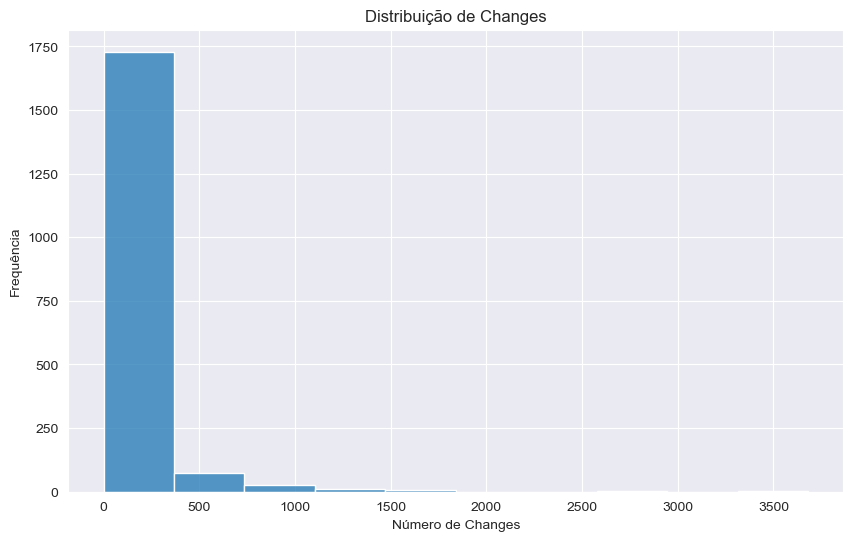

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(summary_per_file_sorted['changes'], bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [24]:
! pip install numpy --quiet

In [25]:
import numpy as np

data = summary_per_file_sorted['changes']

# Calcular histograma
counts, bin_edges = np.histogram(data, bins=10)

# Criar DataFrame a partir dos resultados do histograma
hist_df = pd.DataFrame({'Bin Min': [bin_edges[i] for i in range(len(bin_edges)-1)],
                        'Bin Max': [bin_edges[i+1] for i in range(len(bin_edges)-1)], 
                        'Frequency': counts})

hist_df

,Bin Min,Bin Max,Frequency
0,0.0,368.1,1729
1,368.1,736.2,73
2,736.2,1104.3,27
3,1104.3,1472.4,10
4,1472.4,1840.5,6
5,1840.5,2208.6,0
6,2208.6,2576.7,0
7,2576.7,2944.8,2
8,2944.8,3312.9,0
9,3312.9,3681.0,1


In [26]:
def get_files(bin_min, bin_max):
     return summary_per_file_sorted[ 
        (summary_per_file_sorted['changes'] >= bin_min) & 
        (summary_per_file_sorted['changes'] <= bin_max)
     ].copy()

In [27]:
most_modified_files = get_files(1104, 3681)
most_modified_files

,file,changes
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1054,src/Raven.Studio/typescript/components/pages/r...,2718
1036,src/Raven.Studio/typescript/components/pages/r...,2619
1314,src/Sparrow/Memory.cs,1816
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695
795,src/Raven.Studio/typescript/components/common/...,1605
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508
1040,src/Raven.Studio/typescript/components/pages/r...,1432


In [28]:
most_modified_files['changes'].sum()

31665

In [29]:
most_modified_files['perc']= (most_modified_files['changes'] / total_changes * 100)

In [30]:
most_modified_files

,file,changes,perc
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681,2.054817
1054,src/Raven.Studio/typescript/components/pages/r...,2718,1.517249
1036,src/Raven.Studio/typescript/components/pages/r...,2619,1.461985
1314,src/Sparrow/Memory.cs,1816,1.013732
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810,1.010383
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766,0.985821
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695,0.946187
795,src/Raven.Studio/typescript/components/common/...,1605,0.895947
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508,0.841800
1040,src/Raven.Studio/typescript/components/pages/r...,1432,0.799375


In [31]:
most_modified_files['perc'].sum()

17.676119236351457

In [32]:
list(most_modified_files['file'])

['test/SlowTests/Server/Documents/PeriodicBackup/PeriodicBackupSlowTests.cs',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/regular/CreateDatabaseRegular.tsx',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/CreateDatabaseFromBackup.tsx',
 'src/Sparrow/Memory.cs',
 'src/Raven.Studio/typescript/viewmodels/database/settings/connectionStrings.ts',
 'test/SlowTests/Issues/RavenDB-19922.cs',
 'test/SlowTests/Client/Subscriptions/ConcurrentSubscriptionsTests.cs',
 'src/Raven.Studio/typescript/components/common/CreateDatabase.tsx',
 'test/SlowTests/SparrowTests/ModifyConfigurationTests.cs',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/steps/CreateDatabaseFromBackupStepSource.tsx',
 'test/SlowTests/Issues/RavenDB-19951.cs',
 'src/Raven.Studio/typescript/components/pages/database/settings/connectionStrings/editForms/ElasticSearchConnectionString.tsx',
 'src/Raven.S

In [33]:
len(most_modified_files) / len(summary_per_file) * 100

1.0281385281385282

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


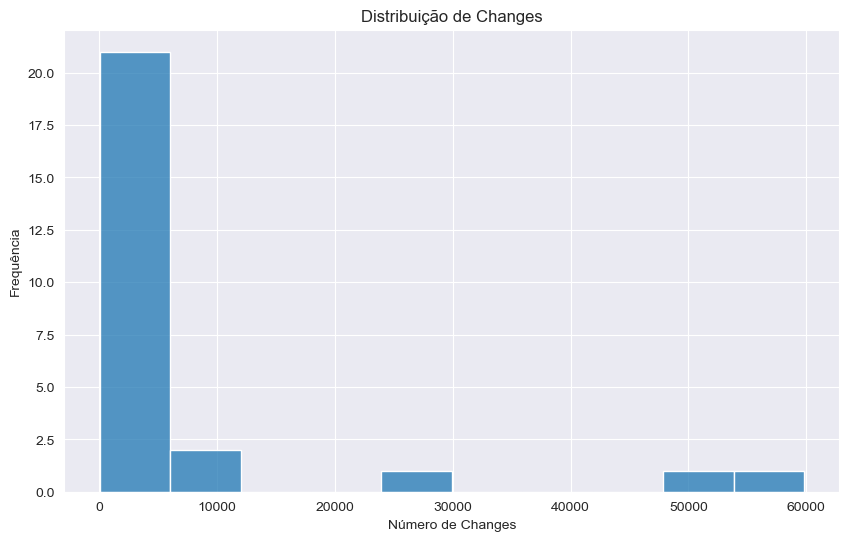

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(summary_per_author_sorted['changes'], bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [35]:
data = summary_per_author_sorted['changes']

# Calcular histograma
counts, bin_edges = np.histogram(data, bins=10)

# Criar DataFrame a partir dos resultados do histograma
hist_df = pd.DataFrame({'Bin Min': [bin_edges[i] for i in range(len(bin_edges)-1)],
                        'Bin Max': [bin_edges[i+1] for i in range(len(bin_edges)-1)], 
                        'Frequency': counts})

hist_df

,Bin Min,Bin Max,Frequency
0,14.0,5995.6,21
1,5995.6,11977.2,2
2,11977.2,17958.8,0
3,17958.8,23940.4,0
4,23940.4,29922.0,1
5,29922.0,35903.6,0
6,35903.6,41885.2,0
7,41885.2,47866.8,0
8,47866.8,53848.4,1
9,53848.4,59830.0,1


In [36]:
d = summary_per_author_sorted.copy()
d['perc'] = d['changes'] / total_changes * 100
d

,author,changes,perc
0,Arkadiusz Paliński,59830,33.398459
2,Damian Olszewski,48448,27.044769
15,Paweł Pekról,27648,15.433739
3,Federico Lois,7070,3.946634
10,Maciej Aszyk,6193,3.457073
23,shaharhikri,4912,2.741990
13,Mateusz Bartosik,4042,2.256336
14,Michał Leśniak,3018,1.684716
20,efrat@ravendb.net,2697,1.505526
24,shiranshalom,2626,1.465893


In [45]:
def get_projects_of_author(author):
    commits_of_author_df = filtered_commits_df[filtered_commits_df['author'] == author]
    result = commits_of_author_df.groupby('code_project')['changes'].sum().reset_index()
    changes = result['changes'].sum()
    result['perc'] = result['changes'] / changes * 100
    return result.sort_values(by='changes', ascending=False)

get_projects_of_author('Arkadiusz Paliński')

,code_project,changes,perc
18,SlowTests,17719,29.726873
15,Raven.Studio,14155,23.747609
14,Raven.Server,12826,21.517968
20,Sparrow.Server,2804,4.704224
10,Raven.Client,2613,4.383787
19,Sparrow,1486,2.493038
4,FastTests,1446,2.425930
2,Corax,1431,2.400765
28,Voron,1327,2.226286
24,Tests.Infrastructure,1157,1.941080


In [46]:
get_projects_of_author('Damian Olszewski')

,code_project,changes,perc
1,Raven.Studio,48441,99.985552
0,Raven.Server,7,0.014448


In [47]:
get_projects_of_author('Paweł Pekról')

,code_project,changes,perc
14,Raven.Server,8795,32.005095
18,SlowTests,7855,28.584425
15,Raven.Studio,4826,17.561863
20,Sparrow.Server,1543,5.614993
10,Raven.Client,1255,4.566958
24,Tests.Infrastructure,671,2.441776
4,FastTests,477,1.735808
28,Voron,465,1.692140
6,InterversionTests,213,0.775109
11,Raven.Debug,192,0.698690


In [40]:
data = filtered_commits_df[filtered_commits_df['root'] == 'src']
data.groupby('code_project')['changes'].sum().reset_index().sort_values(by='changes', ascending=False)

,code_project,changes
4,Raven.Studio,73605
3,Raven.Server,33822
1,Raven.Client,7538
6,Sparrow.Server,5559
7,Voron,4701
0,Corax,3808
5,Sparrow,3178
2,Raven.Embedded,53


In [48]:
def get_authors_of_project(project):
    commits_of_project_df = filtered_commits_df[filtered_commits_df['code_project'] == project]
    result = commits_of_project_df.groupby('author')['changes'].sum().reset_index()
    changes = result['changes'].sum()
    result['perc'] = result['changes'] / changes * 100
    return result.sort_values(by='changes', ascending=False)

get_authors_of_project('Voron')

,author,changes,perc
1,Federico Lois,2765,58.817273
0,Arkadiusz Paliński,1327,28.228037
5,Paweł Pekról,465,9.891512
6,egor,67,1.425229
4,Maciej Aszyk,63,1.340140
2,Grisha Kotler,13,0.276537
3,Karmel Indych,1,0.021272


In [49]:
get_authors_of_project('Raven.Server')

,author,changes,perc
0,Arkadiusz Paliński,12826,37.922063
11,Paweł Pekról,8795,26.003785
17,shaharhikri,3004,8.881793
4,Grisha Kotler,1354,4.003311
15,efrat@ravendb.net,1264,3.737212
3,Federico Lois,1144,3.382414
18,shiranshalom,1130,3.341021
7,Karmel Indych,1124,3.323281
8,Lev Skuditsky,928,2.743776
9,Maciej Aszyk,815,2.409674


In [50]:
get_authors_of_project('Raven.Studio')

,author,changes,perc
1,Damian Olszewski,48441,65.812105
0,Arkadiusz Paliński,14155,19.231031
5,Paweł Pekról,4826,6.556620
4,Mateusz Bartosik,4042,5.491475
3,Marcin Lewandowski,1390,1.888459
6,Rafal Kwiatkowski,680,0.923850
7,danielle9897,52,0.070647
2,Grisha Kotler,16,0.021738
8,shiranshalom,3,0.004076


In [51]:
get_authors_of_project('Raven.Client')

,author,changes,perc
0,Arkadiusz Paliński,2613,34.664367
7,Paweł Pekról,1255,16.648979
4,Maciej Aszyk,1002,13.292651
6,Michał Leśniak,999,13.252852
14,shiranshalom,873,11.581321
8,Stav Lagziel,235,3.117538
3,Karmel Indych,187,2.480764
9,aviv,133,1.764394
2,James Thompson,122,1.618466
10,efrat@ravendb.net,60,0.795967


## Express

Concluídas as análises, é bom ter um resumo consolidado de quais são as principais conclusões. Que podem direcionar a ações.

Pouco mais de 1% dos arquivos representa 7% das alterações nos últimos três meses.

```test/SlowTests/Server/Documents/PeriodicBackup/PeriodicBackupSlowTests.cs```, sozinho, representa mais de 2% das modificações.

60% das modificações foram feitas por dois membros do time: Arkadiusz e Damian que trabalham predominantemente no Raven.Studio